In [2]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.5.dev1
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/lisandro/Documents/mt/tp2
-- Configuring done
-- Generating done
-- Build files hav

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metnum as mt
import os
import seaborn as sns
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

In [4]:
#neighbors for finding the mode in KNN
N_NEIGHBORS = 100
#components for PCA
N_COMPONENTS=40
#number of iterations to find eigenvalues and eigenvectors in power iteration
N_ITERATIONS=5000
#epsilon for power iteration
EPSILON=1e-10
#Training / testing percentage
limit = int(0.8 * 42000) 

df_train = pd.read_csv("../data/train.csv")

#shuffle the train cases.
df_train = df_train.sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_test)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [22]:
%%time

alphas = [1,3,5,7,11,15,25,45,65,100,200]
Neighbors = [1,3,5,7,11,15,25,45,65,100,150]

df_alphas = []
df_neighbors = []
df_acc = []
df_cohen = []

for j in alphas:
    
    pca = mt.PCA(j, N_ITERATIONS, EPSILON)
    pca.fit(X)
    X_pca = pca.transform(X)
        
    for i in Neighbors:
        
        X_train, y_train = X_pca[:limit], y[:limit]
        X_test, y_test = X_pca[limit:], y[limit:]

        clf = mt.KNNClassifier(i)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        cohen = cohen_kappa_score(y_pred, y_test)
    
        df_neighbors.append(i)
        df_alphas.append(j)
        df_acc.append(acc)
        df_cohen.append(cohen)

pca_knn_df = {}
pca_knn_df.setdefault('alpha',df_alphas)
pca_knn_df.setdefault('Número de vecinos',df_neighbors)
pca_knn_df.setdefault('Accuracy',df_acc)
pca_knn_df.setdefault('Cohens Kappa',df_cohen)

df = pd.DataFrame(pca_knn_df)
df.to_csv('pca_knn')

CPU times: user 1h 8min 45s, sys: 5.75 s, total: 1h 8min 51s
Wall time: 1h 8min 45s


### Experimentacion kNN vs PCA + kNN para igual cantidad de componentes

In [26]:
%%time

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

clf = mt.KNNClassifier(3)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

acc_kNN = accuracy_score(pred,y_test)
coh_kNN = cohen_kappa_score(pred, y_test)

pca = mt.PCA(784, N_ITERATIONS, EPSILON)
pca.fit(X)
X_pca = pca.transform(X)

X_train, y_train = X_pca[:limit], y[:limit]
X_test, y_test = X_pca[limit:], y[limit:]

clf = mt.KNNClassifier(3)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

acc_PCA_kNN = accuracy_score(pred,y_test)
coh_PCA_kNN = cohen_kappa_score(pred, y_test)

print(acc_kNN,coh_kNN,acc_PCA_kNN,coh_PCA_kNN)

#0.9660714285714286 0.9622822817978011 0.9675 0.96387089488321

0.9660714285714286 0.9622822817978011 0.9675 0.96387089488321
CPU times: user 14min 38s, sys: 1.56 s, total: 14min 39s
Wall time: 14min 37s


,Unnamed: 0,alpha,Número de vecinos,Accuracy,Cohens Kappa
0,0,1,1,0.243810,0.159456
1,1,1,3,0.267857,0.185053
2,2,1,5,0.272024,0.190021
3,3,1,7,0.278810,0.197629
4,4,1,11,0.284762,0.204266
...,...,...,...,...,...
116,116,200,25,0.953571,0.948384
117,117,200,45,0.945357,0.939249
118,118,200,65,0.940119,0.933422
119,119,200,100,0.932262,0.924681


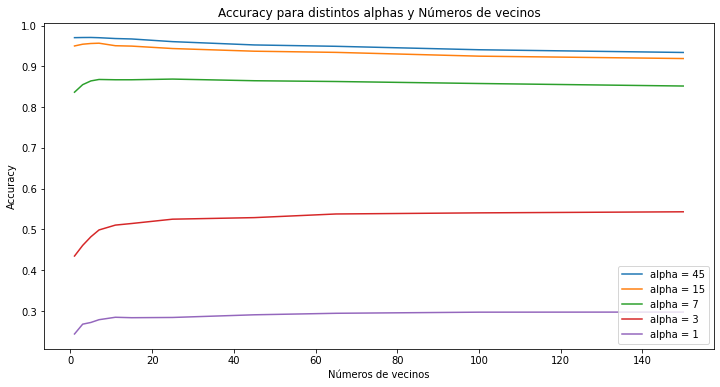

In [40]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,6

alphas = [1,3,7,15,45]

alphas = reversed(alphas)

df = pd.read_csv("pca_knn")
# for x in alphas:    
#     r = df[df['alpha'] == x]
#     r = r.filter(['Número de vecinos', 'Accuracy','Cohens Kappa'])
#     sns.lineplot(data = r, x = 'Número de vecinos', y = 'Accuracy')
#     sns.scatterplot(data = r, x = 'Número de vecinos', y = 'Accuracy')



for x in alphas:    
    r = df[df['alpha'] == x]
    num_vecinos = r['Número de vecinos'].values
    accs = r['Accuracy'].values
    plt.plot(num_vecinos, accs)
    plt.title('Accuracy para distintos alphas y Números de vecinos')
    plt.xlabel('Números de vecinos')
    plt.ylabel('Accuracy')
    
plt.legend(['alpha = 45','alpha = 15','alpha = 7','alpha = 3','alpha = 1']) 
   
df

### testeo PCA para valores entre 1 y 10 con train / total data = 0.85 y set completo

In [17]:
limite = 0.85 * 42000

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

preds = []
vecinos = [i for i in range(1,11)]

for cant_vecinos in vecinos:
    
    clf = mt.KNNClassifier(cant_vecinos)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    preds.append(accuracy_score(pred,y_test))
    

dicss = {
    'Número de vecinos' : vecinos,
    'Accuracy': preds
        }

In [21]:
dff1 = pd.DataFrame(dicss)

dff1.to_csv('accuracy_knn_limite_0.85_cant_vecinos_1_10')